In [1]:
import os
import cv2
import gc
import math
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
from matplotlib import pyplot as plt
from PIL import Image

import torch
from torch import nn
import torchvision
from torchinfo import summary
from torchvision import transforms
import torch.nn.functional as F
from torch.autograd import Variable
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

import config as CFG
from utils import AvgMeter, get_lr


/tmp/ipykernel_21601/2830275748.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, comment, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.comment = list(comment)
        self.encoded_comment = tokenizer(
            list(comment), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_comment.items()
        }
        if os.path.exists(f"{CFG.image_path}/{self.image_filenames[idx]}"):
            image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transforms(image=image)['image']
            item['image'] = torch.tensor(image).permute(2, 0, 1).float()
            item['comment'] = self.comment[idx]

            return item
        else:
            print(f"wrong path : {CFG.image_path}/{self.image_filenames[idx]}")
    
    def __len__(self):
        return len(self.comment)
    
def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True)
            ]
        )

In [3]:
class ImageEncoder(nn.Module):
    def __init__(
      self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super(). __init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool='avg'
        )
        for p in self.model.parameters():
            p.requires_grad = trainable
            
    def forward(self, x):
      return self.model(x)

In [4]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig.from_pretrained(model_name))

        for p in self.model.parameters():
            p.requires_grad = trainable
        
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [5]:
class ProjectionHead(nn.Module):
    def __init__(
            self,
            embedding_dim,
            projection_dim=CFG.projection_dim,
            dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [6]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [7]:
class CLIPModel(nn.Module):
    def __init__(
            self,
            temperature=CFG.temperature,
            image_embedding=CFG.image_embedding,
            text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"] 
        )
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss = (images_loss + texts_loss) / 2.0
        return loss.mean()

In [8]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.comment_path}/results.csv")
    dataframe["id"] = range(len(dataframe))
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [9]:
def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["comment"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [10]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "comment"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()
        
        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

In [11]:
def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "comment"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [12]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [13]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 2)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(2, 2, figsize=(5, 5))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

In [14]:
def main():
    train_losses = []
    valid_losses = []

    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
    )
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        train_losses.append(train_loss.avg)

        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        valid_losses.append(valid_loss.avg)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

    plt.plot(range(1, CFG.epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, CFG.epochs + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

Epoch: 1


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 8


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 9


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 11


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 12


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 20


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 21


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 22


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 27


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 28


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model!


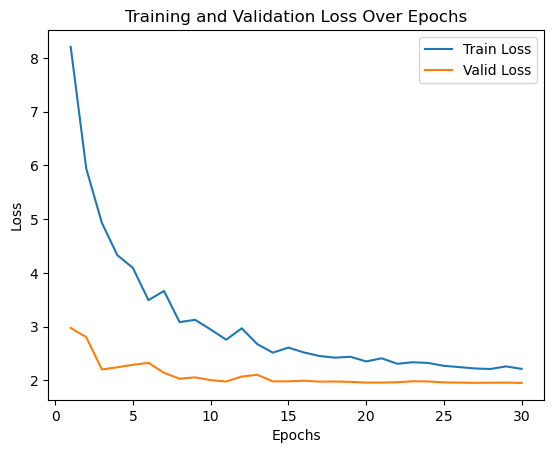

In [15]:
if __name__ == "__main__":
    main()

In [16]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "/home/youngwoong/ppj/notebook/wkit_project/best.pt")

  0%|          | 0/3 [00:00<?, ?it/s]

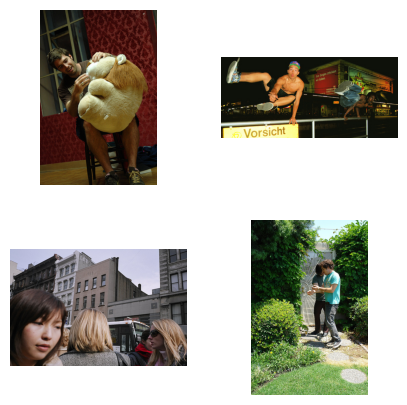

In [17]:
find_matches(model, 
             image_embeddings,
             query="A young man hanging over the side of a boat",
             image_filenames=valid_df['image'].values,
             n=9)

In [18]:
df = pd.read_csv("/home/youngwoong/hdd/results.csv")
df['id'] = range(len(df))
df.tail()

,image,comment_number,comment,id
133019,998845445.jpg,0.0,A man in shorts and a Hawaiian shirt leans ov...,133019
133020,998845445.jpg,1.0,A young man hanging over the side of a boat,133020
133021,998845445.jpg,2.0,A man is leaning off of the side of a blue an...,133021
133022,998845445.jpg,3.0,A man riding a small boat in a harbor,133022
133023,998845445.jpg,4.0,A man on a moored blue and white boat with hi...,133023


In [19]:
def visualize_image_feature_map(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor()
    ])
    plt.title('Original Image')
    plt.imshow(image)
    plt.show()
    image = transform(image).unsqueeze(0)
    model = ImageEncoder()

    model.eval()
    with torch.no_grad():
        layer_feature = model.model.conv1(image)
    
    feature_maps = layer_feature.squeeze().detach().cpu().numpy()
    feature_maps = feature_maps.transpose(1, 2, 0)

    selected_channel = 1
    plt.title('Image Feature Map(conv1)')
    plt.imshow(feature_maps[:, :, selected_channel], cmap='viridis')
    plt.show()

In [20]:
def visualize_text_feature_map():
    

SyntaxError: incomplete input (2473172483.py, line 2)

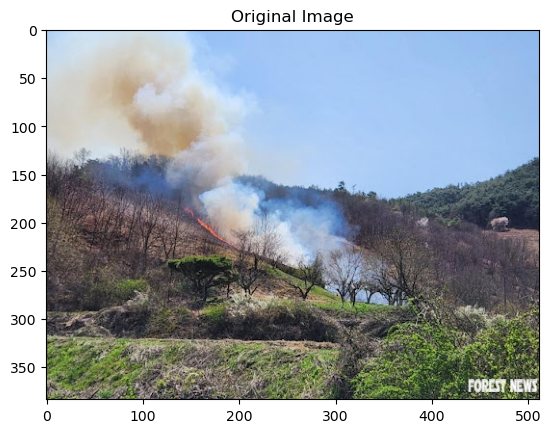

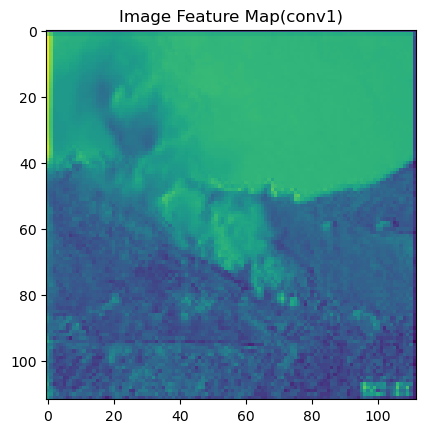

In [ ]:
visualize_image_feature_map("/home/youngwoong/ppj/notebook/wkit_project/test.jpg")

In [ ]:
image_encoder = ImageEncoder()
summary(model=image_encoder, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ImageEncoder                                  [1, 2048]                 --
├─ResNet: 1-1                                 [1, 2048]                 --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       

In [ ]:
text_encoder = TextEncoder()
text_encoder.model 

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li